Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 52.36it/s]
C:\Users\Prasanna_Redy\anaconda3\envs\IIR_Work\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Prasanna_Redy\anaconda3\envs\IIR_Work\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


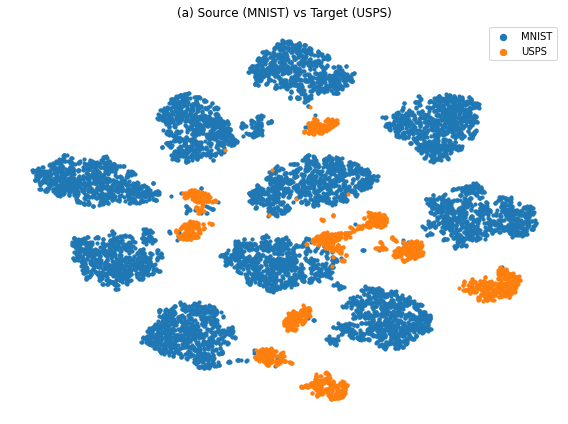

C:\Users\Prasanna_Redy\anaconda3\envs\IIR_Work\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Prasanna_Redy\anaconda3\envs\IIR_Work\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


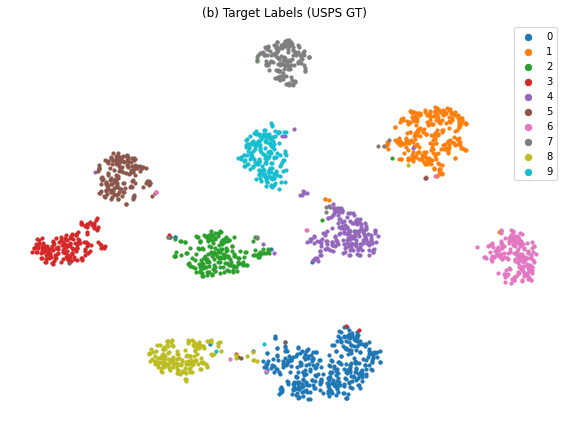

C:\Users\Prasanna_Redy\anaconda3\envs\IIR_Work\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Prasanna_Redy\anaconda3\envs\IIR_Work\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
<ipython-input-3-31a32f6aacb3>:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label_names[lab] if label_names else str(lab), s=10)


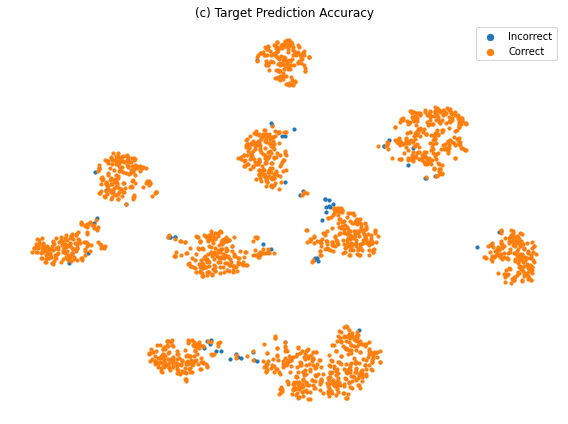

In [3]:
# tsne_visualization.ipynb

import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from tqdm import tqdm

def extract_features(model_G, model_F1, loader, device):
    model_G.eval()
    model_F1.eval()

    features = []
    labels = []
    predictions = []

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device)
            feats = model_G(x)
            logits = model_F1(feats)

            features.append(feats.view(x.size(0), -1).cpu())
            labels.append(y.cpu())
            predictions.append(torch.argmax(logits, dim=1).cpu())

    return torch.cat(features), torch.cat(labels), torch.cat(predictions)

def plot_tsne(X, labels=None, title="", palette="tab10", label_names=None):
    X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X)

    plt.figure(figsize=(8, 6))
    if labels is not None:
        for lab in np.unique(labels):
            idx = labels == lab
            plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label_names[lab] if label_names else str(lab), s=10)
        plt.legend(markerscale=2)
    else:
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=10)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# ----------- Load Models and Data ----------------

from models import FeatureGenerator, Classifier
from datasets import get_data_loaders

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_G = FeatureGenerator().to(device)
model_F1 = Classifier().to(device)

src='mnist'
tgt='usps'
domain = src + '_' + tgt

# Load trained checkpoint
ckpt = torch.load("./checkpoints/"+domain+"/checkpoint.pth", map_location=device)
model_G.load_state_dict(ckpt["model_G"])
model_F1.load_state_dict(ckpt["model_F1"])

# Load Data
loaders = get_data_loaders(batch_size=32, image_size=32)
_, loader_src = loaders[src]
_, loader_tgt = loaders[tgt]

# ----------- Extract Features -------------------

feats_src, labels_src, preds_src = extract_features(model_G, model_F1, loader_src, device)
feats_tgt, labels_tgt, preds_tgt = extract_features(model_G, model_F1, loader_tgt, device)

# Concatenate for combined TSNE
X = torch.cat([feats_src, feats_tgt]).numpy()
domain_labels = np.array([0]*len(feats_src) + [1]*len(feats_tgt))  # 0=source, 1=target

# ----------- Plot (a) Domain Distribution --------
plot_tsne(X, domain_labels, title="(a) Source (MNIST) vs Target (USPS)", label_names=["MNIST", "USPS"])

# ----------- Plot (b) Ground Truth Labels --------
plot_tsne(feats_tgt.numpy(), labels_tgt.numpy(), title="(b) Target Labels (USPS GT)")

# ----------- Plot (c) Classification Accuracy -----
correct = (labels_tgt == preds_tgt).numpy()
plot_tsne(feats_tgt.numpy(), correct, title="(c) Target Prediction Accuracy", label_names=["Incorrect", "Correct"])
